# Vectorization

## Import our corpus readers

In [4]:
import nltk
import os
import string
import sys

# Import out corpus readers
sys.path.append(os.path.join('..', 'libraries'))
import TMN

## Load corpora

In [5]:
# Set up our corpora
text_dir = os.path.join('..', 'data', 'texts')
pickle_dir = os.path.join('..', 'data', 'pickled')
corpus = TMN.TMNCorpusReader(text_dir)
pcorpus = TMN.PickledCorpusReader(pickle_dir)

## Textbook vectorizer code

In [102]:
# Tokenization function
def tokenize(text):
    stem = nltk.stem.SnowballStemmer('english')
    text = text.lower()

    for token in nltk.word_tokenize(text):
        if token in string.punctuation: continue
        yield stem.stem(token)

# NLTK versions
def nltk_frequency_vectorize(corpus):

    # The NLTK frequency vectorize method. NOTE ERROR IN TEXTBOOK CODE.
    from collections import defaultdict

    def vectorize(doc):
        features = defaultdict(int)

        for token in tokenize(doc):
            features[token] += 1

        return features

    return map(vectorize, corpus)


def nltk_one_hot_vectorize(corpus):
    # The NLTK one hot vectorize method
    def vectorize(doc):
        return {
            token: True
            for token in tokenize(doc)
        }

    return map(vectorize, corpus)


def nltk_tfidf_vectorize(corpus):

    from nltk.text import TextCollection

    corpus = [list(tokenize(doc)) for doc in corpus]
    texts = TextCollection(corpus)

    for doc in corpus:
        yield {
            term: texts.tf_idf(term, doc)
            for term in doc
        }


# Gensim versions
def gensim_frequency_vectorize(corpus):
    # The Gensim frequency vectorize method
    import gensim
    
    corpus  = [list(tokenize(doc)) for doc in corpus]
    id2word = gensim.corpora.Dictionary(corpus)

    return [
        id2word.doc2bow(doc) for doc in corpus # Note error in textbook
    ]


def gensim_one_hot_vectorize(corpus):
    # The Gensim one hot vectorize method
    import gensim
    import numpy as np

    corpus  = [list(tokenize(doc)) for doc in corpus]
    id2word = gensim.corpora.Dictionary(corpus)

    corpus  = np.array([
        [(token[0], 1) for token in id2word.doc2bow(doc)]
        for doc in corpus
    ])

    return corpus


def gensim_tfidf_vectorize(corpus):
    import gensim

    corpus  = [list(tokenize(doc)) for doc in corpus]
    lexicon = gensim.corpora.Dictionary(corpus)

    tfidf   = gensim.models.TfidfModel(dictionary=lexicon, normalize=True)
    vectors = [tfidf[lexicon.doc2bow(vector)] for vector in corpus]

    #lexicon.save_as_text('test.txt')
    #tfidf.save('tfidf.pkl')

    return vectors


def gensim_doc2vec_vectorize(corpus):
    from gensim.models.doc2vec import TaggedDocument, Doc2Vec

    corpus = [list(tokenize(doc)) for doc in corpus]
    docs   = [
        TaggedDocument(words, ['d{}'.format(idx)])
        for idx, words in enumerate(corpus)
    ]
    model = Doc2Vec(docs, vector_size=5, min_count=0)
    return model.docvecs


# Scikit-learn versions

def sklearn_frequency_vectorize(corpus):
    # The Scikit-Learn frequency vectorize method
    from sklearn.feature_extraction.text import CountVectorizer

    vectorizer = CountVectorizer()
    return vectorizer.fit_transform(corpus)


def sklearn_one_hot_vectorize(corpus):
    # The Sklearn one hot vectorize method

    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.preprocessing import Binarizer

    freq    = CountVectorizer()
    vectors = freq.fit_transform(corpus)

    print(len(vectors.toarray()[0]))

    onehot  = Binarizer()
    vectors = onehot.fit_transform(vectors.toarray())

    print(len(vectors[0]))

def sklearn_tfidf_vectorize(corpus):
    from sklearn.feature_extraction.text import TfidfVectorizer

    tfidf = TfidfVectorizer()
    return tfidf.fit_transform(corpus)

## Examine a toy corpus

In [95]:
# The demo corpus object
demo_corpus = [
    "The elephant sneezed at the sight of potatoes.",
    "Bats can see via echolocation. See the bat sight sneeze!",
    "Wondering, she opened the door to the studio.",
]

In [96]:
freq_vectorizers = [
    gensim_frequency_vectorize(demo_corpus),
    nltk_frequency_vectorize(demo_corpus),
    sklearn_frequency_vectorize(demo_corpus)
]

tfidf_vectorizers = [
    gensim_tfidf_vectorize(demo_corpus),
    nltk_tfidf_vectorize(demo_corpus),
    sklearn_tfidf_vectorize(demo_corpus)
]

In [97]:
for i in freq_vectorizers:
    print(i)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2)], [(4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 2), (11, 1)], [(6, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1)]]
  (0, 9)	1
  (0, 7)	1
  (0, 12)	1
  (0, 0)	1
  (0, 14)	1
  (0, 6)	1
  (0, 16)	2
  (1, 13)	1
  (1, 1)	1
  (1, 5)	1
  (1, 18)	1
  (1, 10)	2
  (1, 3)	1
  (1, 2)	1
  (1, 12)	1
  (1, 16)	1
  (2, 15)	1
  (2, 17)	1
  (2, 4)	1
  (2, 8)	1
  (2, 11)	1
  (2, 19)	1
  (2, 16)	2


In [98]:
for i in tfidf_vectorizers:
    print(i)

[[(0, 0.4837965208957426), (1, 0.4837965208957426), (2, 0.4837965208957426), (3, 0.4837965208957426), (4, 0.17855490118826325), (5, 0.17855490118826325)], [(4, 0.10992597952954358), (5, 0.10992597952954358), (7, 0.5956913654963344), (8, 0.2978456827481672), (9, 0.2978456827481672), (10, 0.5956913654963344), (11, 0.2978456827481672)], [(12, 0.408248290463863), (13, 0.408248290463863), (14, 0.408248290463863), (15, 0.408248290463863), (16, 0.408248290463863), (17, 0.408248290463863)]]
<generator object nltk_tfidf_vectorize at 0x1a2919fed0>
  (0, 16)	0.44730460893892116
  (0, 6)	0.37867626873820165
  (0, 14)	0.37867626873820165
  (0, 0)	0.37867626873820165
  (0, 12)	0.28799306292785165
  (0, 7)	0.37867626873820165
  (0, 9)	0.37867626873820165
  (1, 16)	0.1786694534059618
  (1, 12)	0.23006945204561577
  (1, 2)	0.30251368128649075
  (1, 3)	0.30251368128649075
  (1, 10)	0.6050273625729815
  (1, 18)	0.30251368128649075
  (1, 5)	0.30251368128649075
  (1, 1)	0.30251368128649075
  (1, 13)	0.3025

In [99]:
for i in nltk_frequency_vectorize(demo_corpus):
    print(i)

defaultdict(<class 'int'>, {'the': 2, 'eleph': 1, 'sneez': 1, 'at': 1, 'sight': 1, 'of': 1, 'potato': 1})
defaultdict(<class 'int'>, {'bat': 2, 'can': 1, 'see': 2, 'via': 1, 'echoloc': 1, 'the': 1, 'sight': 1, 'sneez': 1})
defaultdict(<class 'int'>, {'wonder': 1, 'she': 1, 'open': 1, 'the': 2, 'door': 1, 'to': 1, 'studio': 1})


In [103]:
# doc2vec embeddings
demo_out = gensim_doc2vec_vectorize(demo_corpus)
for i in range(len(demo_out)):
    print(demo_out[i])

[-0.01528136  0.00787425  0.07749055 -0.06102659 -0.07178673]
[-0.05901285 -0.08293881 -0.07245144  0.00230478 -0.02285959]
[-0.00761298 -0.05833431  0.04777717 -0.08239508  0.0503199 ]


## Sklearn and visualize

In [126]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

def preproc(token):
    """
    Stems and lowercases a token. Discards punctuation.
    """
    stem = nltk.stem.SnowballStemmer('english')
    if token in string.punctuation:
        return None
    else:
        return stem.stem(token)
    
tfidf = TfidfVectorizer(
    lowercase = True,
    preprocessor = preproc,
    max_df = 0.7,
    min_df = 2,
    use_idf = True,
)
vectors = tfidf.fit_transform(corpus.docs())
print(f'{vectors.shape[0]} documents, {vectors.shape[1]} features.')

40 documents, 29332 features.
CPU times: user 25 s, sys: 1.37 s, total: 26.3 s
Wall time: 26.7 s


In [127]:
# Reduce dimensions with PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced = pca.fit_transform(vectors.toarray())
print(f'{reduced.shape[0]} documents, {reduced.shape[1]} PCA features.')

40 documents, 2 PCA features.


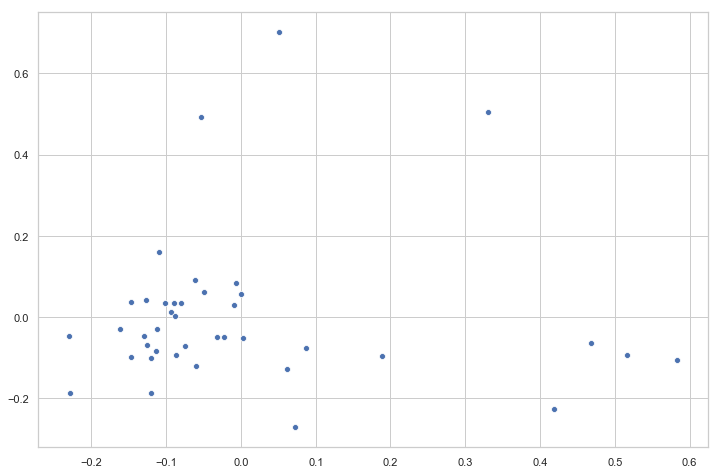

In [128]:
# Plot with matplotlib and Seaborn
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
sns.set_style('whitegrid')

sns.scatterplot(reduced[:,0], reduced[:,1])
plt.show()

In [129]:
# Get document labels
labels = []
for file in corpus.fileids():
    labels.append(corpus.categories(fileids=file))

nations = [lab[0] for lab in labels]
genders = [lab[2] for lab in labels]

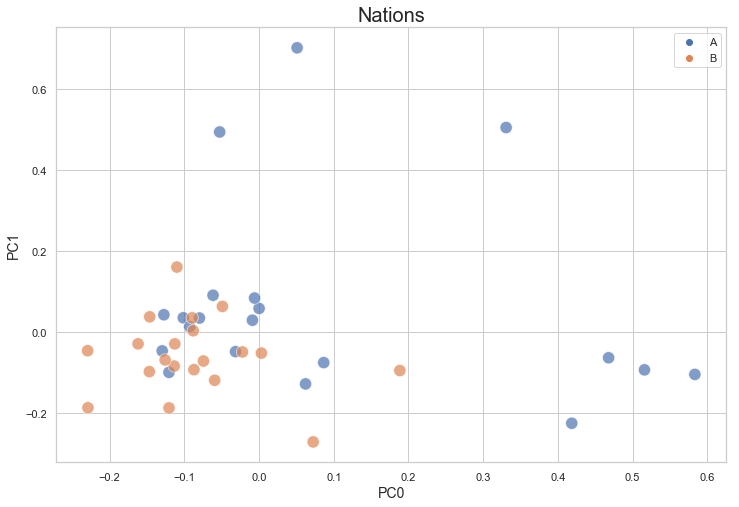

In [130]:
# Color by nation
sns.scatterplot(reduced[:,0], reduced[:,1], hue=nations, s=150, alpha=0.7)
plt.xlabel("PC0", size=14)
plt.ylabel("PC1", size=14)
plt.title("Nations", size=20)
plt.show()

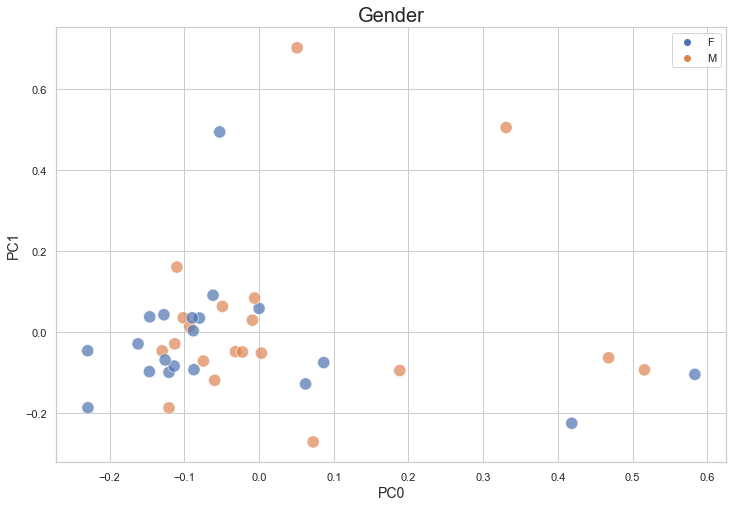

In [131]:
# By author gender
sns.scatterplot(reduced[:,0], reduced[:,1], hue=genders, s=150, alpha=0.7)
plt.xlabel("PC0", size=14)
plt.ylabel("PC1", size=14)
plt.title("Gender", size=20)
plt.show()